In [1]:
# 20SMA 터지
## 안전의 10%를 위험으로 전환
## 생략 가능

# 60SMA 터지
## 남은 안전의 50%를 위험으로 전환
## 5일 분할 매수

# 120SMA 터지
## 남은 안전의 50%를 위험으로 전환
## 5일 분할 매수

# 120SMA 터지 & RSI 35 미만
## 100% 위험으로 전환
## 40일 분할 매수

In [34]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt

def compute_rsi(series, period=14):
    delta = series.diff(1)
    gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

def simulate_attacker_shield_strategy(data, attacker = 'QLD', shield = 'SGOV', initial_cash=200000, monthly_investment=200000):
    df = data.copy()
    df['20MA'] = df[attacker].rolling(window=20).mean()
    df['60MA'] = df[attacker].rolling(window=60).mean()
    df['120MA'] = df[attacker].rolling(window=120).mean()
    df['RSI'] = compute_rsi(df[attacker], period=14)
    df = df.dropna()

    shield_units = initial_cash / df[shield][0]
    attacker_units = 0
    total_cash_invested = initial_cash

    df[f'{shield}_Units'] = 0
    df[f'{attacker}_Units'] = 0
    df['Portfolio_Value'] = 0
    df['Total_Investment'] = 0
    df['Buy_Signal'] = ''
    
    # 새로운 컬럼: 활성화된 매수 시그널 및 남은 일수
    df['Active_Buy_Signal'] = ''
    df['Days_Remaining'] = ''

    active_signals = {}  # 실행 중인 매수 시그널 { '20MA': 남은 일수, '60MA': 남은 일수 }

    for i in range(len(df)):
        if i % 21 == 0 and i > 0:
            shield_units += monthly_investment / df[shield][i]
            total_cash_invested += monthly_investment
        
        shield_cash = shield_units * df[shield][i]
        buy_signal = []

        # # 20MA 조건
        # if '20MA' in active_signals and active_signals['20MA'] > 0:
        #     buy_amount = shield_cash * 0.1
        #     attacker_units += buy_amount / df[attacker][i]
        #     shield_units -= buy_amount / df[shield][i]
        #     active_signals['20MA'] -= 1
        # elif df[attacker][i] < df['20MA'][i]:
        #     active_signals['20MA'] = 1  # 1일 매수
        #     buy_signal.append('20MA')

        # # 60MA 조건
        # if '60MA' in active_signals and active_signals['60MA'] > 0:
        #     buy_amount = shield_cash * 0.5 / 5
        #     attacker_units += buy_amount / df[attacker][i]
        #     shield_units -= buy_amount / df[shield][i]
        #     active_signals['60MA'] -= 1
        # elif df[attacker][i] < df['60MA'][i]:
        #     active_signals['60MA'] = 5  # 3일 매수
        #     buy_signal.append('60MA')

        # # 120MA 조건
        # if '120MA' in active_signals and active_signals['120MA'] > 0:
        #     buy_amount = shield_cash * 0.5 / 5
        #     attacker_units += buy_amount / df[attacker][i]
        #     shield_units -= buy_amount / df[shield][i]
        #     active_signals['120MA'] -= 1
        # elif df[attacker][i] < df['120MA'][i]:
        #     active_signals['120MA'] = 5  # 3일 매수
        #     buy_signal.append('120MA')

        # 120MA + RSI 35 이하 조건
        if '120MA + RSI < 35' in active_signals and active_signals['120MA + RSI < 35'] > 0:
            buy_amount = shield_cash / 40
            attacker_units += buy_amount / df[attacker][i]
            shield_units -= buy_amount / df[shield][i]
            active_signals['120MA + RSI < 35'] -= 1
        elif df[attacker][i] < df['120MA'][i] and df['RSI'][i] < 35:
            active_signals['120MA + RSI < 35'] = 40  # 10일 매수
            buy_signal.append('120MA + RSI < 35')

        # 현재 실행 중인 매수 시그널과 남은 일수 업데이트
        active_signals = {k: v for k, v in active_signals.items() if v > 0}
        active_buy_signal_str = ', '.join(active_signals.keys())
        days_remaining_str = ', '.join([f"{k}: {v}" for k, v in active_signals.items()])

        df.loc[df.index[i], f'{shield}_Units'] = shield_units
        df.loc[df.index[i], f'{attacker}_Units'] = attacker_units
        df.loc[df.index[i], 'Portfolio_Value'] = attacker_units * df[attacker][i] + shield_units * df[shield][i]
        df.loc[df.index[i], 'Total_Investment'] = total_cash_invested
        df.loc[df.index[i], 'Buy_Signal'] = ', '.join(buy_signal)
        df.loc[df.index[i], 'Active_Buy_Signal'] = active_buy_signal_str
        df.loc[df.index[i], 'Days_Remaining'] = days_remaining_str

    return df

def simulate_attacker_simple_strategy(data, attacker='QLD', initial_cash=200000, monthly_investment=200000):
    df = data.copy()
    
    # 초기 투자
    attacker_units = initial_cash / df[attacker][0]  # 초기 현금으로 attacker 매수
    total_cash_invested = initial_cash  # 총 투자된 금액
    
    df[f'{attacker}_Units'] = 0
    df['Portfolio_Value'] = 0
    df['Total_Investment'] = 0

    for i in range(len(df)):
        # 매월 첫 번째 거래일에 200만 원 적립하여 attacker 매수
        if i % 21 == 0 and i > 0:
            attacker_units += monthly_investment / df[attacker][i]
            total_cash_invested += monthly_investment

        # 기록 저장
        df.loc[df.index[i], f'{attacker}_Units'] = attacker_units
        df.loc[df.index[i], 'Portfolio_Value'] = attacker_units * df[attacker][i]
        df.loc[df.index[i], 'Total_Investment'] = total_cash_invested
    
    return df


In [62]:
df_imp = pd.read_csv('trend_data.csv', index_col=0)
df_imp.index = pd.to_datetime(df_imp.index)

assets = ['QLD', 'SGOV']
dataset = df_imp[assets].copy()['2018-01-01':]
dataset = dataset/ dataset.iloc[0]

In [63]:
strategy_df = simulate_attacker_shield_strategy(dataset, attacker='QLD', initial_cash=0, monthly_investment=500)
strategy_df['Adj_return'] = strategy_df['Portfolio_Value'] / strategy_df['Total_Investment']
bm_df = simulate_attacker_simple_strategy(dataset[119:], attacker='QLD', initial_cash=0, monthly_investment=500)
bm_df['Adj_return'] = bm_df['Portfolio_Value'] / bm_df['Total_Investment']

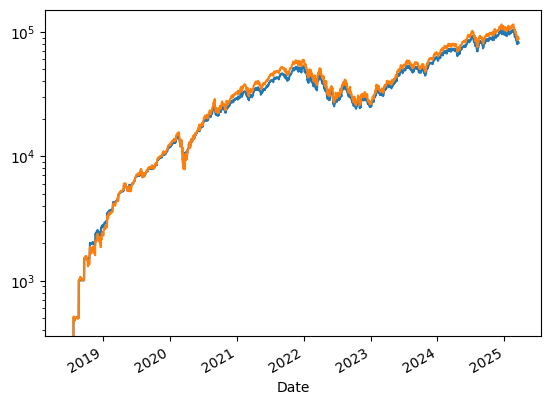

In [64]:
strategy_df['Portfolio_Value'].plot()
bm_df['Portfolio_Value'].plot()
plt.yscale('log')

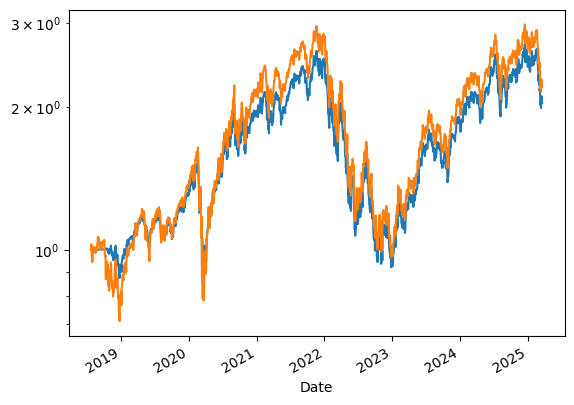

In [65]:
strategy_df['Adj_return'].plot()
bm_df['Adj_return'].plot()
plt.yscale('log')

In [54]:
temp

,QLD,SGOV,20MA,60MA,120MA,RSI,SGOV_Units,QLD_Units,Portfolio_Value
Date,,,,,,,,,
2023-09-12,1.424115,1.024253,1.403628,1.428894,1.286172,59.027844,488.306506,347.581856,995.145964
2023-09-13,1.434513,1.024559,1.406051,1.429248,1.289793,54.899210,488.306506,347.581856,998.909572
2023-09-14,1.457301,1.024865,1.411117,1.430037,1.293401,70.704818,488.306506,347.581856,1006.979823
2023-09-15,1.406195,1.025069,1.415144,1.430616,1.296526,56.917587,195.346880,561.120685,989.289001
2023-09-18,1.409734,1.025171,1.419524,1.430726,1.299804,54.400628,78.154948,647.206851,992.512023
...,...,...,...,...,...,...,...,...,...
2025-03-12,2.052647,1.104676,2.363078,2.451640,2.391410,21.468177,0.000000,2424.133332,4975.889291
2025-03-13,1.977504,1.105006,2.334811,2.441241,2.389579,22.227324,0.000000,2424.133332,4793.732573
2025-03-14,2.071766,1.105336,2.307632,2.431162,2.388616,30.892148,0.000000,2529.913841,5241.389279


In [44]:
temp['QLD']/temp['QLD'][0]

Date
2023-09-12    1.000000
2023-09-13    1.007301
2023-09-14    1.023303
2023-09-15    0.987416
2023-09-18    0.989902
                ...   
2025-03-12    1.441349
2025-03-13    1.388584
2025-03-14    1.454774
2025-03-17    1.473507
2025-03-18    1.473507
Name: QLD, Length: 381, dtype: float64

In [ ]:
# 기본 패키지
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import datetime as dt
import json

In [49]:
def investment_simulation(price_series, attack, shield, monthly_investment):
    """
    특정 자산 가격의 월간 시계열 데이터와 일정한 월 투자 금액을 기반으로
    투자 시작 시점별로 n년 동안의 투자 경과를 시뮬레이션하는 함수.

    Parameters:
        price_series (pd.Series): 월 단위 자산 가격 시계열 데이터 (Index: 날짜)
        monthly_investment (float): 매월 투자하는 금액
        years (int): 투자 기간 (년)

    Returns:
        List[pd.DataFrame]: 각 투자 시작 시점별 매월 투자 결과를 포함한 데이터프레임 리스트
    """
    total_invested = 0  # 총 투자 금액
    total_units = 0  # 총 매수한 자산 개수
    records = []  # 매월 기록 저장
    for i in range(len(price_series)):
        date = price_series.index[i]  # 현재 투자 월
        price = price_series.iloc[i]  # 해당 월의 가격
        
        # 매월 투자
        total_invested += monthly_investment
        total_units += monthly_investment / price  # 해당 월의 가격으로 매수
        
        # 현재 평가 금액 계산
        final_value = total_units * price
        
        # 기록 저장
        records.append({
            "Date": date,
            "Total_Invested": total_invested,
            "Total_Units": total_units,
            "Final_Value": final_value
        })
        
    return pd.DataFrame(records).set_index("Date")

In [50]:
investment_simulation(df_imp['SGOV'], 1000)

,Total_Invested,Total_Units,Final_Value
Date,,,
1975-01-02,1000,10.000000,1.000000e+03
1975-01-03,2000,19.997200,2.000280e+03
1975-01-06,3000,29.991659,3.000829e+03
1975-01-07,4000,39.983400,4.001645e+03
1975-01-08,5000,49.972503,5.002702e+03
...,...,...,...
2025-03-10,12657000,36420.111465,3.303820e+07
2025-03-11,12658000,36421.213609,3.304578e+07
2025-03-12,12659000,36422.315753,3.304678e+07


In [28]:
import pandas as pd
import numpy as np

def calculate_rsi(series, period=14):
    """
    RSI(Relative Strength Index)를 계산하는 함수

    Parameters:
    - series (pd.Series): 종가asset 데이터
    - period (int): RSI를 계산할 기간 (기본값: 14일)

    Returns:
    - pd.Series: 계산된 RSI 값
    """
    delta = series.diff()

    # 상승과 하락 분리
    gain = np.where(delta > 0, delta, 0)
    loss = np.where(delta < 0, -delta, 0)

    # 이동 평균 계산
    avg_gain = pd.Series(gain).rolling(window=period, min_periods=period).mean()
    avg_loss = pd.Series(loss).rolling(window=period, min_periods=period).mean()

    # 첫 번째 RSI 값 이후에는 지수 이동 평균으로 계산
    avg_gain = avg_gain.shift(1).fillna(0).ewm(alpha=1/period, min_periods=period).mean()
    avg_loss = avg_loss.shift(1).fillna(0).ewm(alpha=1/period, min_periods=period).mean()

    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    rsi.index = series.index
    return rsi

def trading_strategy(df, asset, initial_safe_allocation=1.0, monthly_deposit=0.1):
    conditions = [
        {'sma_period': 20, 'rsi_threshold': None, 'allocation_ratio': 0.1, 'split_days': 1},
        {'sma_period': 60, 'rsi_threshold': None, 'allocation_ratio': 0.5, 'split_days': 5},
        {'sma_period': 120, 'rsi_threshold': None, 'allocation_ratio': 0.5, 'split_days': 5},
        {'sma_period': 120, 'rsi_threshold': 35, 'allocation_ratio': 1.0, 'split_days': 40}
    ]

    df['Safe_Allocation'] = initial_safe_allocation
    df['Risk_Allocation'] = 0.0
    df['Total_Asset'] = initial_safe_allocation

    # 매월 정해진 날에 입금
    first_trading_days = df.groupby(df.index.to_period('M')).head(1).index
    df['Deposit'] = np.where(df.index.isin(first_trading_days), monthly_deposit, 0)
    df['Safe_Allocation'] += df['Deposit']

    # 위험 자산 수익률 추적
    df['Risk_Return'] = df[asset].pct_change().fillna(0)

    for condition in conditions:
        sma_col = f"SMA_{condition['sma_period']}"
        df[sma_col] = df[asset].rolling(window=condition['sma_period']).mean()

        trigger = (df[asset] < df[sma_col])
        if condition['rsi_threshold'] is not None:
            trigger &= (df['RSI'] < condition['rsi_threshold'])

        allocation_per_day = condition['allocation_ratio'] / condition['split_days']

        for i in range(1, len(df)):
            if trigger.iloc[i]:
                daily_allocation = min(allocation_per_day, df['Safe_Allocation'].iloc[i-1])
                df.loc[df.index[i], 'Risk_Allocation'] += daily_allocation
                df.loc[df.index[i], 'Safe_Allocation'] -= daily_allocation

            # 위험 자산 수익률 반영
            df.loc[df.index[i], 'Risk_Allocation'] *= (1 + df.loc[df.index[i], 'Risk_Return'])

            # 총 자산 업데이트
            df.loc[df.index[i], 'Total_Asset'] = df.loc[df.index[i], 'Safe_Allocation'] + df.loc[df.index[i], 'Risk_Allocation']

    return df

In [29]:
df_imp = pd.read_csv('trend_data.csv', index_col=0)
df_imp.index = pd.to_datetime(df_imp.index)

asset = 'QQQ'
dataset = df_imp[[asset]].copy()

In [30]:
dataset['RSI'] = calculate_rsi(dataset[asset])
dataset = dataset.dropna()

In [32]:
# 전략 실행
result = trading_strategy(dataset, 'QQQ', initial_safe_allocation=10000*1e4, monthly_deposit=200*1e4)

In [37]:
result

,QQQ,RSI,Safe_Allocation,Risk_Allocation,Total_Asset,Deposit,Risk_Return,SMA_20,SMA_60,SMA_120
Date,,,,,,,,,,
1975-01-22,105.890773,75.807319,102000000.0,0.0,100000000.0,2000000.0,0.000000,NaN,NaN,NaN
1975-01-23,106.528917,75.458723,100000000.0,0.0,100000000.0,0.0,0.006026,NaN,NaN,NaN
1975-01-24,108.064595,75.134668,100000000.0,0.0,100000000.0,0.0,0.014416,NaN,NaN,NaN
1975-01-27,110.931363,75.362208,100000000.0,0.0,100000000.0,0.0,0.026528,NaN,NaN,NaN
1975-01-28,112.452367,76.683083,100000000.0,0.0,100000000.0,0.0,0.013711,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
2025-03-10,51457.134237,41.821024,100000000.0,0.0,100000000.0,0.0,-0.038756,56087.165053,56540.357917,55344.630500
2025-03-11,51334.132076,39.306605,100000000.0,0.0,100000000.0,0.0,-0.002390,55773.402080,56434.813465,55343.634185
2025-03-12,51913.220191,37.088754,100000000.0,0.0,100000000.0,0.0,0.011281,55495.451179,56345.123200,55349.320030


In [45]:
def calculate_sma(series, sma_period):
    """ 이동평균 계산 """
    sma = series.rolling(window=sma_period, min_periods=sma_period).mean()
    return sma


def calculate_rsi(series, period=14):
    """
    RSI(Relative Strength Index)를 계산하는 함수

    Parameters:
    - series (pd.Series): 종가(Close) 데이터
    - period (int): RSI를 계산할 기간 (기본값: 14일)

    Returns:
    - pd.Series: 계산된 RSI 값
    """
    delta = series.diff()

    # 상승과 하락 분리
    gain = np.where(delta > 0, delta, 0)
    loss = np.where(delta < 0, -delta, 0)

    # 이동 평균 계산
    avg_gain = pd.Series(gain).rolling(window=period, min_periods=period).mean()
    avg_loss = pd.Series(loss).rolling(window=period, min_periods=period).mean()

    # 첫 번째 RSI 값 이후에는 지수 이동 평균으로 계산
    avg_gain = avg_gain.shift(1).fillna(0).ewm(alpha=1/period, min_periods=period).mean()
    avg_loss = avg_loss.shift(1).fillna(0).ewm(alpha=1/period, min_periods=period).mean()

    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    rsi.index = series.index
    return rsi


def trading_strategy(df, initial_safe_allocation=1.0):
    """
    투자 전략에 따라 안전 자산을 위험 자산으로 전환하는 함수

    Parameters:
    - df (pd.DataFrame): 'Close' 가격과 'RSI'가 포함된 데이터프레임
    - initial_safe_allocation (float): 초기 안전 자산 비율 (기본값: 1.0, 100%)

    Returns:
    - pd.DataFrame: 각 일자별 투자 비중과 매수 전략
    """
    # 설정된 조건들
    conditions = [
        {'sma_period': 20, 'rsi_threshold': None, 'allocation_ratio': 0.1, 'split_days': 1},
        {'sma_period': 60, 'rsi_threshold': None, 'allocation_ratio': 0.5, 'split_days': 5},
        {'sma_period': 120, 'rsi_threshold': None, 'allocation_ratio': 0.5, 'split_days': 5},
        {'sma_period': 120, 'rsi_threshold': 35, 'allocation_ratio': 1.0, 'split_days': 40}
    ]

    # 초기 자산 상태
    df['Safe_Allocation'] = initial_safe_allocation
    df['Risk_Allocation'] = 0.0

    # 각 조건별 투자 진행
    for condition in conditions:
        sma_col = f"SMA_{condition['sma_period']}"
        df[sma_col] = df['Close'].rolling(window=condition['sma_period']).mean()

        trigger = (df['Close'] > df[sma_col])
        if condition['rsi_threshold'] is not None:
            trigger &= (df['RSI'] < condition['rsi_threshold'])

        allocation_per_day = condition['allocation_ratio'] / condition['split_days']

        for i in range(1, len(df)):
            if trigger.iloc[i]:
                daily_allocation = min(allocation_per_day, df['Safe_Allocation'].iloc[i-1])
                df.loc[df.index[i], 'Risk_Allocation'] += daily_allocation
                df.loc[df.index[i], 'Safe_Allocation'] -= daily_allocation

    return df

In [35]:
df_imp = pd.read_csv('trend_data.csv', index_col=0)
df_imp.index = pd.to_datetime(df_imp.index)

In [42]:
asset = 'QQQ'
dataset = df_imp[[asset]].copy()
for term in [20, 60, 120, 200]:
    dataset[f'SMA_{term}'] = calculate_sma(df_imp[asset], term)
dataset['RSI'] = calculate_rsi(df_imp[asset])

In [46]:
initial_safe_allocation = 1

In [47]:
df = dataset.copy()

In [49]:
conditions = [
    {'sma_period': 20, 'rsi_threshold': None, 'allocation_ratio': 0.1, 'split_days': 1},
    {'sma_period': 60, 'rsi_threshold': None, 'allocation_ratio': 0.5, 'split_days': 5},
    {'sma_period': 120, 'rsi_threshold': None, 'allocation_ratio': 0.5, 'split_days': 5},
    {'sma_period': 120, 'rsi_threshold': 35, 'allocation_ratio': 1.0, 'split_days': 40}
]

# 초기 자산 상태
df['Safe_Allocation'] = initial_safe_allocation
df['Risk_Allocation'] = 0.0

# 각 조건별 투자 진행
for condition in conditions:
    sma_col = f"SMA_{condition['sma_period']}"
    df[sma_col] = df[asset].rolling(window=condition['sma_period']).mean()

    trigger = (df[asset] > df[sma_col])
    if condition['rsi_threshold'] is not None:
        trigger &= (df['RSI'] < condition['rsi_threshold'])

    allocation_per_day = condition['allocation_ratio'] / condition['split_days']

    for i in range(1, len(df)):
        if trigger.iloc[i]:
            daily_allocation = min(allocation_per_day, df['Safe_Allocation'].iloc[i-1])
            df.loc[df.index[i], 'Risk_Allocation'] += daily_allocation
            df.loc[df.index[i], 'Safe_Allocation'] -= daily_allocation

In [54]:
df['Risk_Allocation'].tail(70)

Date
2024-12-03    0.3
2024-12-04    0.3
2024-12-05    0.3
2024-12-06    0.3
2024-12-09    0.3
             ... 
2025-03-10    0.0
2025-03-11    0.0
2025-03-12    0.0
2025-03-13    0.0
2025-03-14    0.0
Name: Risk_Allocation, Length: 70, dtype: float64